# Risk measurement and estimation

One of the measures commonly used in the industry to quantify market risk is Value-at-Risk (VAR). It is used to calculate the capital reserve needed to cover the potential losses that may sustain at a given confidence level and given holding period.

For a random variable $X$ which measures the gain of our portfolio, level $\alpha\in(0,1)$ and horizon $N$, we define **Value-at-Risk** as (negative value of) $\alpha$-quantile of $X$:
$$ VaR_\alpha^N(X) = -F_x^{-1}(\alpha).$$

We are $(1-\alpha)$ certain that we will not lose more than $VaR_\alpha^N(X)$ dollars in the next $N$ days. We should keep that reserve to ensure that we are able to cover potential future losses.

**Expected Shortfall (ES)** at level $\alpha$ is the conditional expectation on a set of worst $\alpha$-quantile outcomes:
$$ ES^N_\alpha(X) = -\mathbb{E}[X|X\leq F_X^{-1}(\alpha)].$$

If the VaR scenario occurs then on average our loss is equal to ES. We should keep that amount of capital so that we are prepared for VaR scenarios.

Both VaR and ES are maps $\rho\colon L^0\to\mathbb{R}$ satisfying
 - monoticity: $X\geq Y \implies \rho(X)\leq\rho(Y)$,
 - cash-additivity: $\rho(X+a) = \rho(X)-a$,
 - normalisation: $\rho(0)=0$,
 - positive homogeneity: $\rho(aX)\leq a\rho(X)$ for $a\geq0$.
 
We interpret $\rho(X)$ as the smallest capital that must be added to $X$ so that $X$ is acceptable.

## Standard VaR estimators

Here are the most popular VaR estimators:
 - **Empirical estimator**:
 $$ \overline{VaR}_\alpha^{emp}(x) = -x_{[n\alpha]},$$
 - **Normal estimator**: 
 $$ \overline{VaR}_\alpha^{norm}(x) = -(\overline{x}+\sigma(x)\Phi^{-1}(\alpha)),$$
 - **Unbiased normal estimator**:
 $$\overline{VaR}_\alpha^{norm_2}(x) = -(\overline{x}+\sigma(x)\sqrt{\frac{n+1}{n}}t^{-1}_{n-1}(\alpha)),$$
 
 where $x=(x_0,\ldots,x_{n-1})$ is a sample of size $n$, $\overline{x}$ is a mean and $\sigma(x)$ is a variance of $x$ while $\Phi$ and $t$ are respectively standard and student's distributions.

### Backtesting

We define 
$ y = x+\rho$
as secured positions.
Assuming the total number of backtesting days is $k$, the exception rate backtesting statistic is given by
$$ T_k(y) = \frac{1}{k}\sum_{j=0}^{k-1}1_{y_j<0}.$$

We count the number of capital breaches (exceptions) in the sample to quantify IMA model performance.

#### Exercise 1:
Implement VaR estimators and compute VaR at level 1% assuming that $X\sim N(1,10)$ and we are given a sample of length 250.

In [1]:
import numpy as np
from scipy.stats import norm, t

In [2]:
def VARemp(alpha,x):
    #empirical var estimator
    #alpha is a number
    #x is a np array of numbers
    x = np.sort(x)
    n = x.size
    return -x[int(n*alpha)]

def VARnorm(alpha,x):
    #normal estimator
    m = np.mean(x)
    s = np.std(x)
    f = norm.ppf(alpha)
    return -(m+s*f)

def VARnorm2(alpha,x):
    #unbiased normal estimator
    m = np.mean(x)
    s = np.std(x)
    n = x.size
    f = t.ppf(alpha,df=n-1)
    return -(m+s*np.sqrt((n+1)/n)*f)

estimators = [VARemp,VARnorm,VARnorm2]

In [3]:
x = np.random.normal(loc=1., scale=10.,size=(250,))

In [4]:
alpha=.01
for est in estimators:
    print(est(alpha,x))

23.84269829289248
22.574310991305893
22.77234053478468


#### Exercise 2:
Repeat above exercise 1000 times and find the average estimation.

In [5]:
from IPython.display import clear_output

In [6]:
E_emp=0
E_norm=0
E_norm2=0

for j in range(10**3):
    x = np.random.normal(loc=1., scale=10.,size=(250,))
    E_emp+=VARemp(.01,x)
    E_norm+=VARnorm(.01,x)
    E_norm2+=VARnorm2(.01,x)
    
    print(j)
    clear_output(wait=True)
    
print('done')
    
E_emp = E_emp/(10**3)
E_norm = E_norm/(10**3)
E_norm2 = E_norm2/(10**3)

print(E_emp,E_norm,E_norm2)

done
22.1853424777149 22.151041847422352 22.34803621994884


#### Exercise 3:
Let us assume we are given an i.i.d. dataset of length $n=500$ of standard normal observations. Do the following:
 - for each $t=1,\ldots,250$ use the empirical and normal estimators at level 1% and dataset $(X_t,\ldots,X_{t+249})$ to project the risk for the next day ($X_{t+250}$).
 - Present the plot of daily P&L moves together with estimated risks.
 - For each estimator count the number of breaches.

In [7]:
import matplotlib.pyplot as plt

In [8]:
X = np.random.normal(loc=0., scale=1.,size=(500,))

empRisks = [VARemp(.01,X[t:t+250]) for t in range(250)]
normRisks = [VARnorm(.01,X[t:t+250]) for t in range(250)]

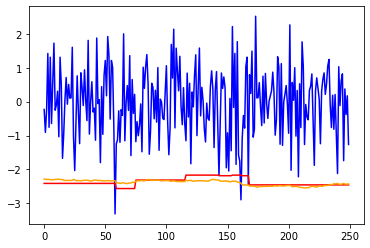

In [9]:
Xtest = X[250:500]

empPlot = [-v for v in empRisks]
normPlot = [-v for v in normRisks]

plt.plot(Xtest,c='blue')
plt.plot(empPlot,c='red')
plt.plot(normPlot,c='orange')

plt.show()

In [10]:
Yemp = Xtest + empRisks
Ynorm = Xtest + normRisks

print(np.count_nonzero(Yemp<0))
print(np.count_nonzero(Ynorm<0))

4
2


#### Exercise 4:
Reapeat the previous exercise 1000 times and find the average number of breaches

In [11]:
empBreach = 0
normBreach = 0

for j in range(10**3):
    X = np.random.normal(loc=0., scale=1.,size=(500,))

    empRisks = [VARemp(.01,X[t:t+250]) for t in range(250)]
    normRisks = [VARnorm(.01,X[t:t+250]) for t in range(250)]
    
    Xtest = X[250:500]
    Yemp = Xtest + empRisks
    Ynorm = Xtest + normRisks
    
    empBreach+=np.count_nonzero(Yemp<0)
    normBreach+=np.count_nonzero(Ynorm<0)
    
    print(j)
    clear_output(wait=True)
    
print('done')
empBreach = empBreach/(10**3)
normBreach = normBreach/(10**3)

done


In [12]:
print(empBreach)
print(normBreach)

2.941
2.668


#### Exercise 5:
Repeat exercise 3 using recent market data. Take daily log-returns of a major stock index (e.g. DAX,FTSE) for the analysis.

In [11]:
import yfinance as yf

In [12]:
start_date = '2020-01-01'
end_date = '2022-10-30'
ticker = 'DAX'
data = yf.download(ticker,start_date,end_date)

[*********************100%***********************]  1 of 1 completed


In [13]:
data.head() 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.538000,28.663000,28.405001,28.500000,26.444674,1500
2020-01-03,27.980000,28.111000,27.969999,27.990000,25.971453,2700
2020-01-06,27.799999,28.004999,27.799999,28.004999,25.985371,600
2020-01-07,28.040001,28.066000,27.955000,27.955000,25.938978,600
2020-01-08,28.155001,28.260000,28.155001,28.260000,26.221983,1700


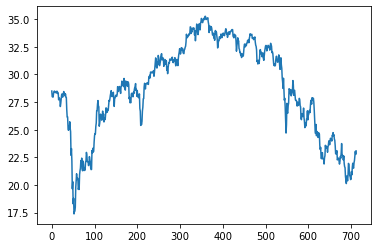

In [14]:
X = np.array(data['Close'])
N = len(X)

plt.plot(X)
plt.show()

In [15]:
empRisks = [VARemp(.01,X[t:t+250]) for t in range(N-250)]
normRisks = [VARnorm(.01,X[t:t+250]) for t in range(N-250)]

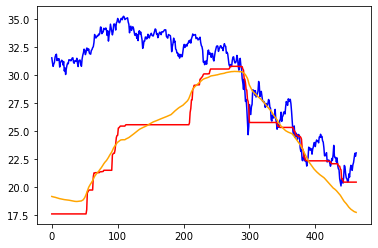

In [16]:
Xtest = X[250:N]

empPlot = [-v for v in empRisks]
normPlot = [-v for v in normRisks]

plt.plot(Xtest,c='blue')
plt.plot(empPlot,c='red')
plt.plot(normPlot,c='orange')

plt.show()

In [17]:
Yemp = Xtest + empRisks
Ynorm = Xtest + normRisks

print(np.count_nonzero(Yemp<0))
print(np.count_nonzero(Ynorm<0))

45
48


# Historical simulation method

Calculating VAR based on historical simulations consists of the following steps:
 - identify risk factors driving the portfolio
 - collect market data for those risk factors for a lookback period
 - generate scenarios based on daily movements of the risk factors
 - reprice the current portfolio assuming that generated scenarios reflect what can happen between today and tomorrow
 - identify the loss of the portfolio which corresponds to the worst loss that can occur with $\alpha$ confidence level
 - if necessary, 1-day VAR can be scaled to N-day VAR by
 $$VAR_N = \sqrt{N}VAR_1.$$

 - Let's assume we want to calculate HS VAR for one asset from our portfolio based on historical data $(S_t)_1^T$.
 - The future $P\&L$ is expressed as
 $$P\&L = S_{T+1}-S_T.$$
 - Since $S_{T+1}$ is a random variable, we need to construct sample of it that we denote $(S_t')_1^T$.
 - To estimate risk we need to calculate shifted scenarios:
     - Multiplicative shifts: $S_t' = S_T\times (S_t/S_{t-1}),$
     - Additive shifts: $S_t' = S_T + (S_t-S_{t-1})$.
 - Then we recover the $P\&L$ vector sample: $P\&L_t = S_t'-S_T$.
 - We use $P\&L$ sample to estimate risk for this asset

Sometimes to calculate $P\&L$'s we may use the **sensitivity based approach**:
$$ P\&L = \delta(\Delta S) + \frac{\gamma}{2}(\Delta S)^2,$$
where $\Delta S = S_i'-S_T$.
This is based on Taylor's expansion of a pricing function $PV$:
$$ \delta = \frac{\partial PV(S)}{\partial S},$$
$$ \gamma = \frac{\partial^2PV(S)}{\partial S^2}.$$

This is used if the **full-revaluation**:
$$ P\&L = PV(S')-PV(S_T)$$
is too complicated.

### Exercise 1:
The financial institution owns a portfolio consisting of options on a single asset. Calculate 10-days VAR at level 5% knowing that the portfolio $\delta = -30$ and $\gamma=-5$. Use the provided daily historical S&P500 proces with lookback period set to 100 days to estimate the risk.

In [19]:
import pandas as pd

In [44]:
df = pd.read_csv('HSBC_lecture6_DATA.csv')
df.tail()

,Data,EURUSD,10-Year German Bond Yield,S&P500,Gold,XYZ,sigma_XYZ
3598,27/07/2020,1.18237,-0.493,3239.41,1931.0,102.8229,0.008351
3599,28/07/2020,1.18143,-0.508,3218.44,1944.6,102.8293,0.009011
3600,29/07/2020,1.17451,-0.501,3258.44,1953.4,102.8205,0.009670
3601,30/07/2020,1.17486,-0.543,3246.22,1942.3,102.8296,0.007752
3602,31/07/2020,1.17102,-0.525,3271.12,1962.8,102.8356,0.005557


In [42]:
SP = np.array(list(df.tail(101)['S&P500']))
shocks = SP[1:]-SP[:-1]

delta = -30
gamma = -5

PLs = delta*shocks + .5*gamma*shocks**2

In [45]:
alpha = .05
var1 = VARemp(alpha,PLs)
var10 = var1*np.sqrt(10)

print(var10)

261698.72760506906


### Exercise 5:
Consider an investement in forward contract for EUR/USD maturing 6 months from now with contracted forward price 1.2 dollars. Calculate 1-day VaR at level 5% for COB 31/07/2020 taking into account that the present value of forward contract is given by
$$ PV = F\exp(-(r-q)T),$$
where $r$ is a spot exchange rate, q is income flow of an asset, $F$ represents forward price and $T$ denotes time to maturity in years. Use recent market data assuming the lookback period of 250 days and $q=0.01$.

In [56]:
prices = np.array(df.tail(251)['EURUSD'])

T=.5
forward_price=1.2
q=.01

curr_price = prices[-1]
S = curr_price*prices[1:]/prices[-1:]

def PV(r):
    return forward_price*np.exp(-(r-q)*T)

PLs = np.array(list(map(PV,S)))-PV(curr_price)

In [57]:
VARemp(.05,PLs)

0.004630983764626007

### Exercise 6:
Consider an european option with current price given by
$$ C = PV(S,\sigma) = SN(d_1)-K\exp(-rT)N(d_2),$$
with
$$ d_1 = \frac{\ln\frac{S}{K}+\left(r+\frac{1}{2}\sigma^2\right)T}{\sigma\sqrt{T}},\ \ d_2=d_1-\sigma\sqrt{T},$$
where $S$ is an underlying price, $K$ is the exercise price at which the option holder can, but is not obliged to, buy the asset, $T$ is time maturity in years, $\sigma$ is a stock volatility, $r$ is a domestic risk free rate, and  $N(d)$ is a cumulative normal distribution function. Based on recent historical data calculate 1-day VaR at risk level 1% for COB 31/07/2020 with 500 days lookback period for one asset portfolio consisting of an European option with underlying XYZ and its volatility sigma_XYZ with exercise price 102.5 dollars maturing 1 year from now.

In [66]:
from scipy.stats import norm

T = 1
r = 0
K = 102.5

alpha = .01

In [65]:
XYZ = np.array(df.tail(501)['XYZ'])
sigmaXYZ = np.array(df.tail(501)['sigma_XYZ'])

curr_XYZ = XYZ[-1]
curr_sigma = sigmaXYZ[-1]

S_XYZ = curr_XYZ*XYZ[1:]/XYZ[:-1]
S_sigma = curr_sigma*sigmaXYZ[1:]/sigmaXYZ[:-1]

def d1(S,sigma):
    a = np.log(S/K) + (r+.5*sigma**2)*T
    b = sigma*np.sqrt(T)
    return a/b

def d2(S,sigma):
    return d1(S,sigma)-sigma*np.sqrt(T)

def PV(S,sigma):
    return S*norm.cdf(d1(S,sigma))-K*np.exp(-r*T)*norm.cdf(d2(S,sigma))

nn = len(S_XYZ)
PLs = np.array([PV(S_XYZ[j],S_sigma[j]) for j in range(nn)])-PV(curr_XYZ,curr_sigma)

In [67]:
VARemp(alpha,PLs)

0.08686985871518971